# Random Forest - Top model according to the SCPM of -4.96

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [5]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [6]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [7]:
df = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [8]:
df_copy = df.drop(
    [
        # Properties
        "Initial setting time",
        "Blaine",
        "Sieve 32 um",
        "Sieve 45 um",
        "CS1",
        "CS3",
        "CS7",
        "Cement_Type",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [9]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [10]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [11]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.710 (0.157)
MAE: -1.351 (0.128)
MAPE: -0.032 (0.002)
R2: 0.691 (0.072)


******
[TEST]
******
RMSE: -2.666 (0.344)
MAE: -2.038 (0.207)
MAPE: -0.046 (0.004)
R2: 0.251 (0.191)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [12]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [13]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-01 11:00:00+00:00,42.93,41.297922,TRAIN
1,2020-01-02 11:00:00+00:00,49.72,48.695354,TRAIN
2,2020-01-02 11:00:00+00:00,39.49,41.297922,TRAIN
3,2020-01-03 11:00:00+00:00,40.55,41.297922,TRAIN
4,2020-01-04 11:00:00+00:00,42.64,41.297922,TRAIN
...,...,...,...,...
1045,2021-12-25 11:00:00+00:00,37.12,39.773592,TEST
1046,2021-12-26 11:00:00+00:00,40.22,39.118626,TEST
1047,2021-12-27 11:00:00+00:00,44.20,45.547106,TEST
1048,2021-12-28 11:00:00+00:00,46.44,45.735606,TEST


<IPython.core.display.Javascript object>

In [14]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)
df_copy_copy

,Date,CaO,SiO2,Al2O3,Fe2O3,MgO,SO3,K2O,Na2O,Total C3S,Total C2S,C3A,C4AF,Free CaO,Loss on Ignition
0,2020-01-01 11:00:00,63.45,19.63,4.90,3.30,3.50,2.89,0.65,0.06,57.88,14.47,5.55,11.26,0.67,3.08
1,2020-01-02 11:00:00,62.22,19.30,4.80,3.23,3.60,3.20,0.67,0.07,57.86,14.79,5.33,11.46,0.69,3.08
2,2020-01-02 11:00:00,62.34,19.28,4.81,3.29,3.48,2.85,0.66,0.06,57.24,14.72,5.52,11.06,0.75,3.38
3,2020-01-03 11:00:00,62.18,19.29,4.85,3.33,3.47,2.87,0.69,0.08,58.03,13.46,5.55,11.33,0.70,3.20
4,2020-01-04 11:00:00,61.97,19.28,4.93,3.39,3.49,2.87,0.72,0.11,58.32,13.38,5.73,11.56,0.63,2.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,2021-12-28 11:00:00,63.32,19.52,4.39,3.25,2.26,3.39,0.61,0.09,59.16,14.46,4.62,12.13,0.64,2.86
1049,2021-12-29 11:00:00,62.24,18.11,4.19,3.03,2.26,3.13,0.59,0.07,52.90,15.11,4.59,10.77,0.76,5.56
1050,2021-12-30 11:00:00,62.23,18.10,4.21,3.03,2.26,3.08,0.59,0.08,52.27,15.41,4.74,10.42,0.85,5.60
1051,2021-12-31 11:00:00,62.27,18.02,4.15,2.99,2.33,3.12,0.60,0.08,53.11,14.65,4.49,10.41,1.05,5.73


<IPython.core.display.Javascript object>

In [15]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-01 11:00:00+00:00,42.93,41.297922,TRAIN,Type I-II
1,2020-01-02 11:00:00+00:00,49.72,48.695354,TRAIN,Type III
2,2020-01-02 11:00:00+00:00,39.49,41.297922,TRAIN,Type I-II
3,2020-01-03 11:00:00+00:00,40.55,41.297922,TRAIN,Type I-II
4,2020-01-04 11:00:00+00:00,42.64,41.297922,TRAIN,Type I-II
...,...,...,...,...,...
1045,2021-12-25 11:00:00+00:00,37.12,39.773592,TEST,Type I-II
1046,2021-12-26 11:00:00+00:00,40.22,39.118626,TEST,Type I-II
1047,2021-12-27 11:00:00+00:00,44.20,45.547106,TEST,Type III
1048,2021-12-28 11:00:00+00:00,46.44,45.735606,TEST,Type III


<IPython.core.display.Javascript object>

In [16]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)

df_pred_copy = df_pred.copy()
df_pred_copy["DATE"] = pd.to_datetime(df_pred_copy["DATE"])
df_pred_copy["DATE"] = df_pred_copy["DATE"].dt.tz_localize(None)

df_copy_merge = df_copy_copy.reset_index(drop=True).merge(
    df_pred_copy.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = "Partner ii"
df_copy_merge["PLANT"] = "Partner ii"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_btsscv_partner_ii.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_btsscv_partner_ii.csv", index=False)

<IPython.core.display.Javascript object>

In [17]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-01 11:00:00+00:00,42.93,41.297922,TRAIN,Type I-II
1,2020-01-02 11:00:00+00:00,49.72,48.695354,TRAIN,Type III
2,2020-01-02 11:00:00+00:00,39.49,41.297922,TRAIN,Type I-II
3,2020-01-03 11:00:00+00:00,40.55,41.297922,TRAIN,Type I-II
4,2020-01-04 11:00:00+00:00,42.64,41.297922,TRAIN,Type I-II
...,...,...,...,...,...
1045,2021-12-25 11:00:00+00:00,37.12,39.773592,TEST,Type I-II
1046,2021-12-26 11:00:00+00:00,40.22,39.118626,TEST,Type I-II
1047,2021-12-27 11:00:00+00:00,44.20,45.547106,TEST,Type III
1048,2021-12-28 11:00:00+00:00,46.44,45.735606,TEST,Type III


<IPython.core.display.Javascript object>

In [18]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [19]:
# # Assuming your DataFrame is named 'df_pred'

# # Filter for test set predictions
# df_test = df_pred[df_pred['SET'] == 'TEST']

# # Convert DATE to datetime objects if not already
# df_test['DATE'] = pd.to_datetime(df_test['DATE'])

# # Create the plot
# fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 10))
# colors = plt.cm.get_cmap("tab20").colors

# # Plot actual values
# ax.plot(df_test['DATE'], df_test['CS28'], label='Actual CS28', marker='o', linestyle='', color=colors[0])
# # Plot predicted values
# ax.plot(df_test['DATE'], df_test['CS28_PRED'], label='Predicted CS28', marker='x', linestyle='', color=colors[2])



# # Add labels and title
# ax.set_xlabel("Date", labelpad=20, fontsize=15)
# ax.set_ylabel('CS28 (MPa)', labelpad=20, fontsize=15)
# plt.title('Random Forest Model Predictions on Test Set')
# ax.legend()
# ax.grid(True)

# # Rotate x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# ax.grid(which="both")
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# # Show the plot
# plt.tight_layout() # Adjust layout for better spacing
# plt.show()


<IPython.core.display.Javascript object>

In [20]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

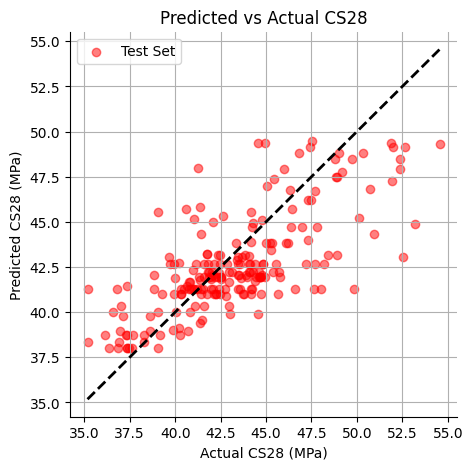

<IPython.core.display.Javascript object>

In [21]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



In [22]:
# # Plot Predicted vs Actual for the test set
# plt.figure(figsize=(5.5, 5.5))
# plt.scatter(
#     test_data["CS28"], test_data["CS28_PRED"], color="dodgerblue", alpha=0.7, label="Test Set"
# )
# plt.plot(
#     [df_pred["CS28"].min(), df_pred["CS28"].max()],
#     [df_pred["CS28"].min(), df_pred["CS28"].max()],
#     color="black", linestyle="--", linewidth=2,
# )
# plt.xlabel("Actual CS28 (MPa)")
# plt.ylabel("Predicted CS28 (MPa)")
# plt.title("Predicted vs Actual CS28")
# plt.legend()
# plt.grid(True)
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig("inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
# plt.show()


<IPython.core.display.Javascript object>

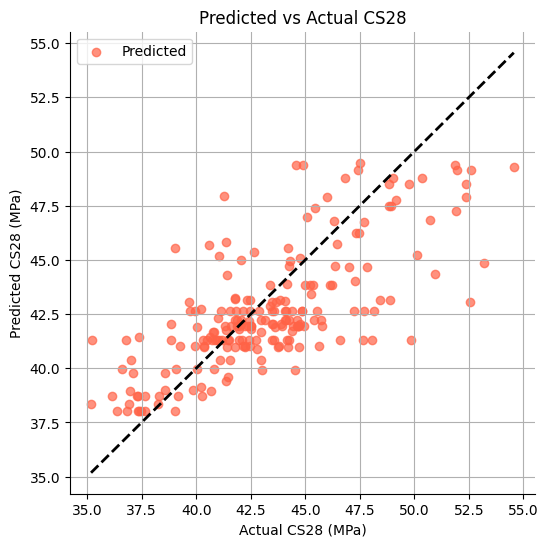

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


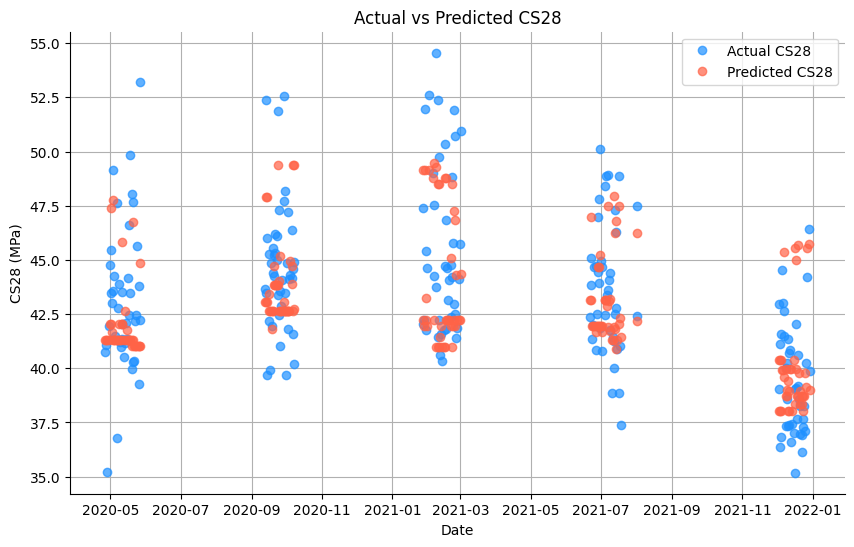

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [25]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# plt.figure(figsize=(10, 6))
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28"],
#     color="dodgerblue",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
# )
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
# )
# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual vs Predicted CS28")
# plt.legend()
# plt.grid(True)

# # Improving x-axis readability
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
# #plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.show()


<IPython.core.display.Javascript object>

In [26]:
# # Set the desired width for the square figure
# square_figure_width = 5  # inches

# # Calculate height of the second figure to maintain proportion
# second_figure_height = (10 / 10) * square_figure_width

# # --- Figure 1 (Square) ---
# plt.figure(figsize=(square_figure_width, square_figure_width))
# plt.scatter(
#     test_data["CS28"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     label="Predicted",
# )
# plt.plot(
#     [min(test_data["CS28"]), max(test_data["CS28"])],
#     [min(test_data["CS28"]), max(test_data["CS28"])],
#     color="black",
#     linestyle="--",
#     linewidth=2,
# )
# plt.xlabel("Actual CS28 (MPa)")
# plt.ylabel("Predicted CS28 (MPa)")
# plt.title("Predicted vs Actual CS28")
# plt.legend()
# plt.grid(True)
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
# )
# plt.show()


<IPython.core.display.Javascript object>

In [27]:
# # --- Figure 2 ---
# plt.figure(figsize=(square_figure_width, second_figure_height))
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28"],
#     color="dodgerblue",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
# )
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
# )
# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual vs Predicted CS28")
# plt.legend()
# plt.grid(True)

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.show()

<IPython.core.display.Javascript object>

In [28]:
# # Filter to only include the test set
# test_data = df_pred[df_pred["SET"] == "TEST"]

# # Plot Actual vs Predicted over Time with "o" Markers (Test Set Only)
# plt.figure(figsize=(10, 7))
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28"],
#     color="blue",
#     alpha=0.5,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
# )
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="red",
#     alpha=0.5,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
# )
# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual vs Predicted CS28")
# plt.legend()
# plt.grid(True)

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.show()

# # usar os dois

<IPython.core.display.Javascript object>

In [29]:
# # Filter to only include the test set
# test_data = df_pred[df_pred["SET"] == "TEST"]

# # Plot Actual vs Predicted over Time with "o" Markers (Test Set Only)
# plt.figure(figsize=(10, 5.5))
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28"],
#     color="blue",
#     alpha=0.5,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
# )
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="red",
#     alpha=0.5,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
# )
# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual vs Predicted CS28")
# plt.legend()
# plt.grid(True)

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.show()

# # usar os dois

<IPython.core.display.Javascript object>

In [30]:
# # Plot Actual vs Predicted over Time with "o" Markers (Test Set Only)
# plt.figure(figsize=(10, 5.5))
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28"],
#     color="steelblue",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
# )
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
# )
# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual vs Predicted CS28")
# plt.legend()
# plt.grid(True)

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.show()


<IPython.core.display.Javascript object>

## Assessing Feature Importance

In [31]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [32]:
df_importances

,CaO,SiO2,Al2O3,Fe2O3,MgO,SO3,K2O,Na2O,Total C3S,Total C2S,C3A,C4AF,Free CaO,Loss on Ignition
Importances - 0,0.000000,0.006089,0.008008,0.005019,0.019573,0.742794,0.000000,0.004910,0.001927,0.002092,0.027734,0.024693,0.001281,0.155880
Importances - 1,0.010792,0.017089,0.027686,0.000000,0.030040,0.633920,0.012829,0.074868,0.014503,0.036336,0.037413,0.070023,0.015527,0.018973
Importances - 2,0.013023,0.000000,0.017181,0.000000,0.034247,0.435691,0.003953,0.023071,0.002181,0.013835,0.067239,0.034165,0.011335,0.344079
Importances - 3,0.068643,0.031942,0.040793,0.005617,0.000000,0.621461,0.035035,0.000000,0.031853,0.034382,0.027837,0.092179,0.010257,0.000000
Importances - 4,0.000000,0.024472,0.000000,0.029401,0.000000,0.615892,0.022753,0.015106,0.048888,0.025704,0.000000,0.119827,0.018885,0.079072


<IPython.core.display.Javascript object>

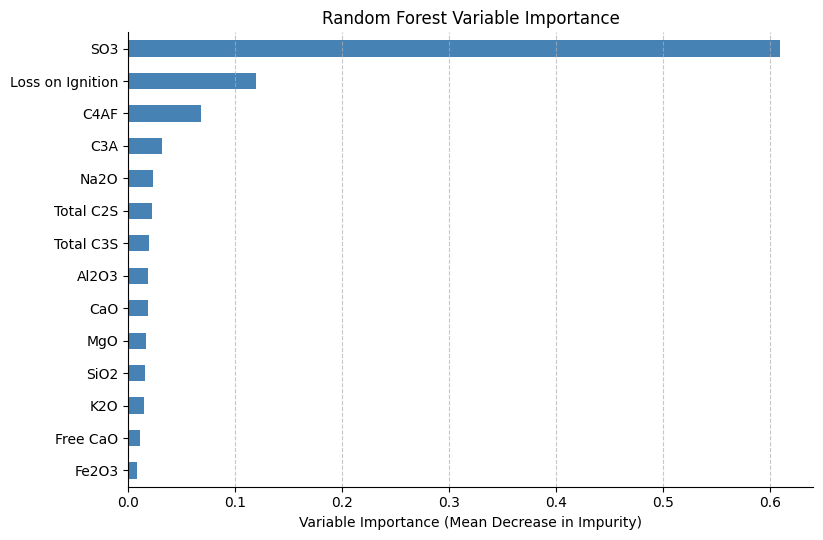

<IPython.core.display.Javascript object>

In [33]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

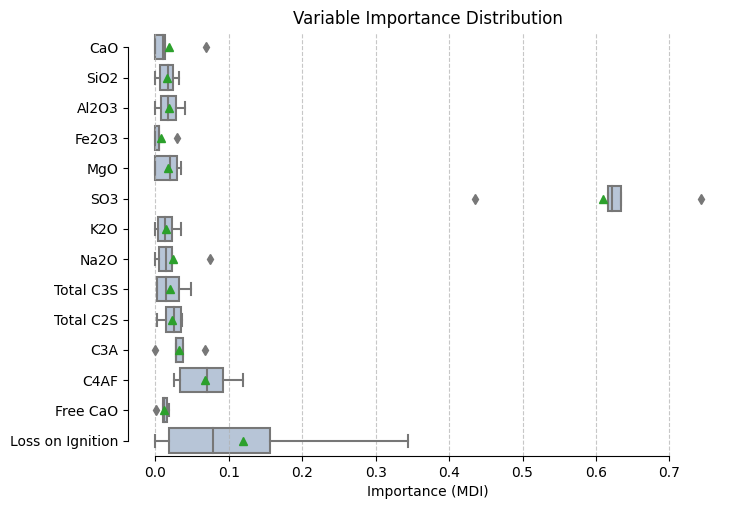

<IPython.core.display.Javascript object>

In [34]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


In [35]:
# warnings.filterwarnings("ignore")
# plt.figure(figsize=(10, 5.5))
# sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=1, showmeans=True)
# sns.despine(trim=True, left=False)
# plt.xlabel("Relevance (MDI)")
# plt.title("Variable Relevance Distribution")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.subplots_adjust(left=0.3)
# plt.show()


<IPython.core.display.Javascript object>

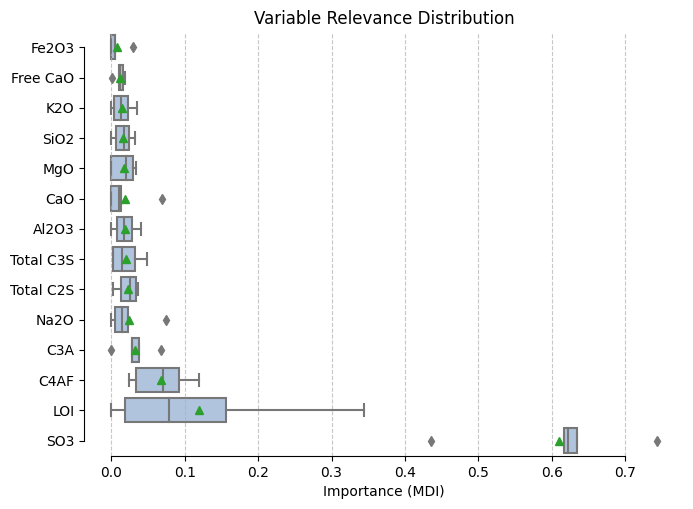

<IPython.core.display.Javascript object>

In [36]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("inn_cm_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


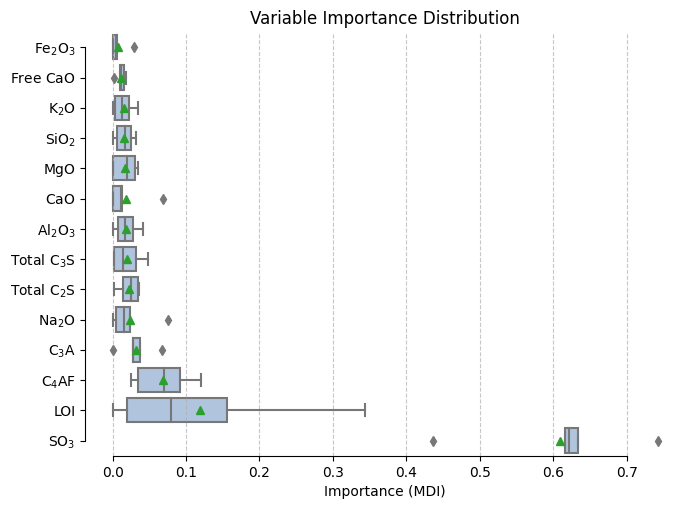

<IPython.core.display.Javascript object>

In [37]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [38]:
df_importances

,CaO,SiO2,Al2O3,Fe2O3,MgO,SO3,K2O,Na2O,Total C3S,Total C2S,C3A,C4AF,Free CaO,Loss on Ignition
Importances - 0,0.000000,0.006089,0.008008,0.005019,0.019573,0.742794,0.000000,0.004910,0.001927,0.002092,0.027734,0.024693,0.001281,0.155880
Importances - 1,0.010792,0.017089,0.027686,0.000000,0.030040,0.633920,0.012829,0.074868,0.014503,0.036336,0.037413,0.070023,0.015527,0.018973
Importances - 2,0.013023,0.000000,0.017181,0.000000,0.034247,0.435691,0.003953,0.023071,0.002181,0.013835,0.067239,0.034165,0.011335,0.344079
Importances - 3,0.068643,0.031942,0.040793,0.005617,0.000000,0.621461,0.035035,0.000000,0.031853,0.034382,0.027837,0.092179,0.010257,0.000000
Importances - 4,0.000000,0.024472,0.000000,0.029401,0.000000,0.615892,0.022753,0.015106,0.048888,0.025704,0.000000,0.119827,0.018885,0.079072


<IPython.core.display.Javascript object>

In [39]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.018492,0.028672,0.000000,0.000000,0.010792,0.013023,0.068643
SiO2,5.0,0.015918,0.013051,0.000000,0.006089,0.017089,0.024472,0.031942
Al2O3,5.0,0.018734,0.016087,0.000000,0.008008,0.017181,0.027686,0.040793
Fe2O3,5.0,0.008007,0.012253,0.000000,0.000000,0.005019,0.005617,0.029401
MgO,5.0,0.016772,0.016216,0.000000,0.000000,0.019573,0.030040,0.034247
SO3,5.0,0.609951,0.110404,0.435691,0.615892,0.621461,0.633920,0.742794
K2O,5.0,0.014914,0.014259,0.000000,0.003953,0.012829,0.022753,0.035035
Na2O,5.0,0.023591,0.030030,0.000000,0.004910,0.015106,0.023071,0.074868
Total C3S,5.0,0.019871,0.020306,0.001927,0.002181,0.014503,0.031853,0.048888
Total C2S,5.0,0.022470,0.014443,0.002092,0.013835,0.025704,0.034382,0.036336


<IPython.core.display.Javascript object>

In [40]:
df_importances.mean(axis=0)

CaO                 0.018492
SiO2                0.015918
Al2O3               0.018734
Fe2O3               0.008007
MgO                 0.016772
SO3                 0.609951
K2O                 0.014914
Na2O                0.023591
Total C3S           0.019871
Total C2S           0.022470
C3A                 0.032045
C4AF                0.068177
Free CaO            0.011457
Loss on Ignition    0.119601
dtype: float64

<IPython.core.display.Javascript object>

In [41]:
df_importances.std(axis=0, ddof=0)

CaO                 0.025645
SiO2                0.011673
Al2O3               0.014389
Fe2O3               0.010960
MgO                 0.014504
SO3                 0.098748
K2O                 0.012753
Na2O                0.026859
Total C3S           0.018162
Total C2S           0.012919
C3A                 0.021590
C4AF                0.035482
Free CaO            0.005946
Loss on Ignition    0.124723
dtype: float64

<IPython.core.display.Javascript object>

In [42]:
df_copy.nunique()

Date                693
CaO                 226
SiO2                182
Al2O3                89
Fe2O3                56
MgO                 178
SO3                  78
K2O                  32
Na2O                 18
Total C3S           630
Total C2S           561
C3A                 232
C4AF                224
Free CaO             98
Loss on Ignition    173
dtype: int64

<IPython.core.display.Javascript object>

In [43]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [44]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [45]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

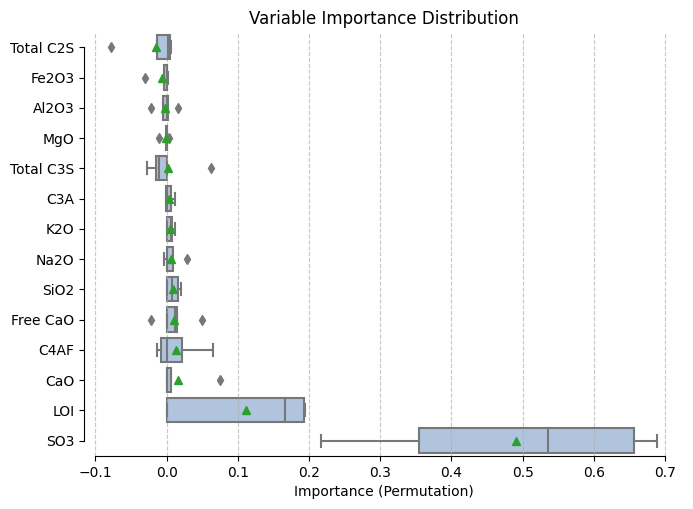

<IPython.core.display.Javascript object>

In [46]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

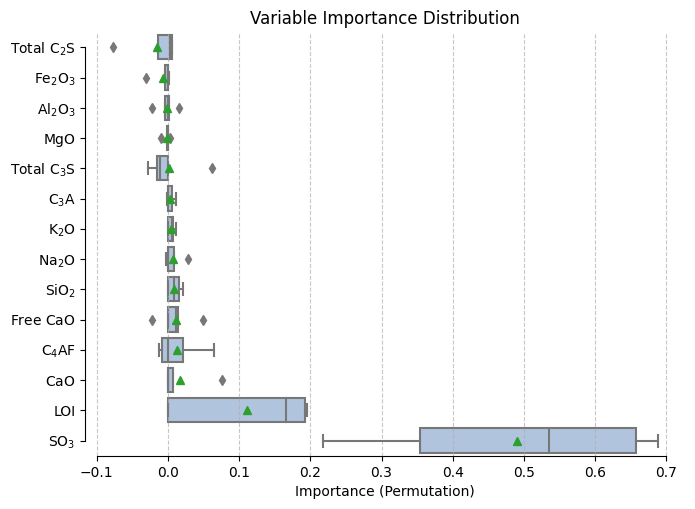

<IPython.core.display.Javascript object>

In [47]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [48]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Total C2S,5.0,-0.015412,0.035707,-0.077673,-0.013437,0.002431,0.005191,0.006426
Fe2O3,5.0,-0.006696,0.013616,-0.030777,-0.004080,0.000000,0.000000,0.001375
Al2O3,5.0,-0.001877,0.013818,-0.022309,-0.004590,0.000000,0.001366,0.016147
MgO,5.0,-0.001452,0.005098,-0.010116,-0.000583,0.000000,0.000000,0.003440
Total C3S,5.0,0.001830,0.035373,-0.027762,-0.014790,-0.010863,0.000000,0.062564
C3A,5.0,0.003227,0.005628,-0.001386,-0.000522,0.000000,0.006398,0.011647
K2O,5.0,0.004844,0.004906,0.000000,0.000000,0.005772,0.006978,0.011471
Na2O,5.0,0.006872,0.012971,-0.002953,0.000000,0.000000,0.008550,0.028762
SiO2,5.0,0.009040,0.009419,0.000000,0.000000,0.008128,0.016270,0.020800
Free CaO,5.0,0.010907,0.026191,-0.022349,0.000830,0.011504,0.014624,0.049924


<IPython.core.display.Javascript object>

In [49]:
perm_importances_df

,Total C2S,Fe2O3,Al2O3,MgO,Total C3S,C3A,K2O,Na2O,SiO2,Free CaO,C4AF,CaO,LOI,SO3
0,0.006426,0.001375,0.001366,-0.010116,0.000000,0.006398,0.000000,0.008550,0.008128,0.011504,0.021699,0.000000,0.194856,0.217435
1,-0.013437,0.000000,0.016147,0.003440,-0.010863,-0.000522,0.006978,-0.002953,0.016270,-0.022349,0.065002,0.000000,0.000000,0.535535
2,0.005191,0.000000,-0.004590,-0.000583,-0.014790,-0.001386,0.000000,0.028762,0.000000,0.014624,-0.007758,0.006772,0.166408,0.354179
3,-0.077673,-0.004080,-0.022309,0.000000,-0.027762,0.011647,0.005772,0.000000,0.000000,0.000830,-0.012926,0.075404,0.000000,0.656574
4,0.002431,-0.030777,0.000000,0.000000,0.062564,0.000000,0.011471,0.000000,0.020800,0.049924,0.000000,0.000000,0.193152,0.688180


<IPython.core.display.Javascript object>

In [50]:
perm_importances_df.mean(axis=0)

Total C2S   -0.015412
Fe2O3       -0.006696
Al2O3       -0.001877
MgO         -0.001452
Total C3S    0.001830
C3A          0.003227
K2O          0.004844
Na2O         0.006872
SiO2         0.009040
Free CaO     0.010907
C4AF         0.013203
CaO          0.016435
LOI          0.110883
SO3          0.490381
dtype: float64

<IPython.core.display.Javascript object>

In [51]:
perm_importances_df.std(axis=0, ddof=0)

Total C2S    0.031938
Fe2O3        0.012178
Al2O3        0.012359
MgO          0.004560
Total C3S    0.031639
C3A          0.005034
K2O          0.004388
Na2O         0.011601
SiO2         0.008424
Free CaO     0.023426
C4AF         0.028466
CaO          0.029601
LOI          0.091096
SO3          0.179908
dtype: float64

<IPython.core.display.Javascript object>

In [52]:
from sklearn.metrics import make_scorer

def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        "RMSE Test": [rmse],
        "MAE Test": [mae],
        "MAPE Test": [mape],
        "R2 Test": [r2]
    })

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

# Convert the SCPM function to a scorer that can be used in permutation_importance
scmp_scorer = make_scorer(compute_scmp, greater_is_better=False)


<IPython.core.display.Javascript object>

In [53]:
# # Compute feature importances using the custom SCPM scoring function
# perm_importances = []

# for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
#     pipeline.fit(x.iloc[train_idx], y[train_idx])

#     # Extract the trained model and imputer
#     model = pipeline.named_steps["estimator"]
#     imputer = pipeline.named_steps["imputer"]
    
#     # Compute permutation importance with SCPM as the scoring function
#     result = permutation_importance(
#         model,
#         imputer.transform(x.iloc[test_idx]),
#         y[test_idx],
#         n_repeats=10,
#         random_state=SEED,
#         n_jobs=-1,
#         scoring=scmp_scorer  # Use the custom SCPM scorer
#     )
#     perm_importances.append(result.importances_mean)


<IPython.core.display.Javascript object>

In [54]:
# # Convert lists to DataFrames
# mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
# perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# # Calculate the mean importance for each feature
# mean_importances = perm_importances_df.mean().sort_values()

# # Reorder the DataFrame columns based on mean importance
# perm_importances_df = perm_importances_df[mean_importances.index]

# perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# plt.figure(figsize=(10, 5.5))
# sns.boxplot(
#     data=perm_importances_df,
#     orient="h",
#     color="lightsteelblue",
#     saturation=1,
#     showmeans=True,
# )
# sns.despine(trim=True, left=False)
# plt.xlabel("Relevance (Permutation)")
# plt.title("Permutation Variable Relevance Distribution")
# plt.grid(axis="x", linestyle="--", alpha=0.7)
# plt.subplots_adjust(left=0.3)
# plt.show()

<IPython.core.display.Javascript object>

In [55]:
# plt.figure(figsize=(10, 5.5))
# sns.boxplot(
#     data=perm_importances_df,
#     orient="h",
#     color="lightsteelblue",
#     saturation=1,
#     showmeans=True,
# )
# sns.despine(trim=True, left=False)


<IPython.core.display.Javascript object>

In [56]:
# # Plot for Permutation Importance Relevance with a contrasting color
# plt.figure(figsize=(10, 5.5))
# sns.boxplot(
#     data=perm_importances_df,
#     orient="h",
#     color="lightsteelblue",
#     saturation=1,
#     showmeans=True,
# )
# sns.despine(trim=True, left=False)

# plt.title("Permutation Feature Relevance Distribution")
# plt.xlabel("Relevance (Permutation)")
# # plt.ylabel("Feature")
# plt.tight_layout()
# plt.grid(axis="x", linestyle="--", alpha=0.7)
# plt.subplots_adjust(left=0.3)
# plt.show()

<IPython.core.display.Javascript object>

In [57]:
# # Plot the distribution of importance scores across folds
# plt.figure(figsize=(12, 7))
# # sns.boxplot(data=mdi_importances_df, orient="h", color="skyblue", saturation=0.7)
# sns.boxplot(
#     data=perm_importances_df, orient="h", color="salmon", saturation=0.7, showmeans=True
# )
# plt.title("Feature Importance Distribution Across Folds")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>

In [58]:
# # Average the importance values over all folds
# mdi_importances_mean = np.mean(mdi_importances, axis=0)
# perm_importances_mean = np.mean(perm_importances, axis=0)

# # Create a DataFrame for easy comparison and plotting
# importances_df = pd.DataFrame(
#     {
#         "Feature": x.columns,
#         "MDI Importance": mdi_importances_mean,
#         "Permutation Importance": perm_importances_mean,
#     }
# ).sort_values(by="Permutation Importance", ascending=False)

# df_importances_sorted = df_importances_sorted.rename(
#     columns={"Loss on Ignition": "LOI"}
# )

# # Plotting the importances
# importances_df.set_index("Feature").plot(
#     kind="barh", figsize=(10, 7), color=["skyblue", "salmon"]
# )
# plt.title("Feature Importance: MDI vs Permutation")
# plt.xlabel("Importance Score")
# plt.show()

<IPython.core.display.Javascript object>

In [59]:
# # Convert lists to DataFrames
# mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
# perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)

# # Average the importance values over all folds
# mdi_importances_mean = mdi_importances_df.mean(axis=0)
# perm_importances_mean = perm_importances_df.mean(axis=0)

# # Create a combined DataFrame for plotting
# importances_df = pd.DataFrame(
#     {
#         "Feature": x.columns,
#         "MDI Importance Mean": mdi_importances_mean,
#         "Permutation Importance Mean": perm_importances_mean,
#     }
# ).sort_values(by="Permutation Importance Mean", ascending=False)

# # Plot the mean importance values
# importances_df.set_index("Feature").plot(
#     kind="barh", figsize=(10, 7), color=["skyblue", "salmon"]
# )
# plt.title("Feature Importance: Mean MDI vs Permutation")
# plt.xlabel("Importance Score")
# plt.show()

# # Plot the distribution of importance scores across folds
# plt.figure(figsize=(12, 7))
# sns.boxplot(data=mdi_importances_df, orient="h", color="skyblue", saturation=0.7)
# sns.boxplot(data=perm_importances_df, orient="h", color="salmon", saturation=0.7)
# plt.title("Feature Importance Distribution Across Folds")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

# # # Combined plot: Mean importance with distribution as boxplots
# # fig, ax = plt.subplots(figsize=(12, 7))
# # sns.boxplot(data=mdi_importances_df, orient="h", color="skyblue", saturation=0.5, ax=ax)
# # sns.boxplot(data=perm_importances_df, orient="h", color="salmon", saturation=0.5, ax=ax)
# # importances_df.set_index("Feature").plot(
# #     kind="barh", color=["darkblue", "darkred"], ax=ax, alpha=0.7, linewidth=2
# # )
# # plt.title("Feature Importance: Mean and Distribution")
# # plt.xlabel("Importance Score")
# # plt.ylabel("Feature")
# # plt.tight_layout()
# # plt.show()

<IPython.core.display.Javascript object>

In [60]:
# # Plot the distribution of importance scores across folds
# plt.figure(figsize=(12, 7))
# sns.boxplot(
#     data=mdi_importances_df, orient="h", color="skyblue", saturation=0.7, showmeans=True
# )
# # sns.boxplot(data=perm_importances_df, orient="h", color="salmon", saturation=0.7)
# plt.title("Feature Importance Distribution Across Folds")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>

In [61]:
# # Plot the distribution of importance scores across folds
# plt.figure(figsize=(12, 7))
# # sns.boxplot(data=mdi_importances_df, orient="h", color="skyblue", saturation=0.7)
# sns.boxplot(
#     data=perm_importances_df, orient="h", color="salmon", saturation=0.7, showmeans=True
# )
# plt.title("Feature Importance Distribution Across Folds")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>

In [62]:
# plt.figure(figsize=(14, 8))

# # Create a DataFrame that stacks the two importance DataFrames
# stacked_importances = pd.concat(
#     [mdi_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='MDI'),
#      perm_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='Permutation')],
#     axis=0
# )

# sns.boxplot(x='Importance', y='Feature', hue='Type', data=stacked_importances, palette=["skyblue", "salmon"])
# plt.title("Feature Importance Distribution Across Folds (MDI vs Permutation)")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [63]:
# plt.figure(figsize=(14, 8))

# # Create a DataFrame that stacks the two importance DataFrames
# stacked_importances = pd.concat(
#     [mdi_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='MDI'),
#      perm_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='Permutation')],
#     axis=0
# )

# g = sns.FacetGrid(stacked_importances, row="Type", aspect=2, height=4, sharex=True, sharey=True)
# g.map(sns.boxplot, "Importance", "Feature", palette=["skyblue"], orient="h", showmeans=True)
# g.add_legend()
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle("Feature Importance Distribution Across Folds (MDI vs Permutation)")
# plt.show()


<IPython.core.display.Javascript object>

In [64]:
# # Create a combined DataFrame for plotting
# importances_df = pd.DataFrame(
#     {
#         "Feature": x.columns,
#         "MDI Importance": mdi_importances_mean,
#         "Permutation Importance": perm_importances_mean,
#     }
# ).sort_values(by="Permutation Importance", ascending=False)

# # Plot the mean importance values
# importances_df.set_index("Feature").plot(
#     kind="barh", figsize=(10, 7), color=["skyblue", "salmon"]
# )
# plt.title("Feature Importance: MDI vs Permutation")
# plt.xlabel("Importance Score")
# plt.show()


<IPython.core.display.Javascript object>

In [65]:
# plt.figure(figsize=(10, 7))
# plt.scatter(mdi_importances_mean, perm_importances_mean, color="mediumseagreen")
# plt.title("MDI vs Permutation Importance")
# plt.xlabel("MDI Importance")
# plt.ylabel("Permutation Importance")
# for i, feature in enumerate(x.columns):
#     plt.text(mdi_importances_mean[i], perm_importances_mean[i], feature, fontsize=9)
# plt.grid(True)
# plt.show()


<IPython.core.display.Javascript object>

In [66]:
# plt.figure(figsize=(12, 7))

# # Boxplot for MDI Importance
# sns.boxplot(data=mdi_importances_df, orient="h", color="skyblue", saturation=0.7)
# plt.title("MDI Feature Importance Distribution Across Folds")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 7))

# # Boxplot for Permutation Importance
# sns.boxplot(data=perm_importances_df, orient="h", color="salmon", saturation=0.7)
# plt.title("Permutation Feature Importance Distribution Across Folds")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [67]:
# # Compute the mean and standard deviation of importance values over all folds
# mdi_importances_mean = mdi_importances_df.mean(axis=0)
# mdi_importances_std = mdi_importances_df.std(axis=0)
# perm_importances_mean = perm_importances_df.mean(axis=0)
# perm_importances_std = perm_importances_df.std(axis=0)

<IPython.core.display.Javascript object>

In [68]:
# # Create a combined DataFrame for plotting
# importances_df = pd.DataFrame({
#     "Feature": x.columns,
#     "MDI Importance Mean": mdi_importances_mean,
#     "MDI Importance Std": mdi_importances_std,
#     "Permutation Importance Mean": perm_importances_mean,
#     "Permutation Importance Std": perm_importances_std
# }).sort_values(by="Permutation Importance Mean", ascending=False)

# # Plot the mean importance values with standard deviation as error bars
# fig, ax = plt.subplots(figsize=(10, 5.5))
# importances_df.plot.barh(
#     x="Feature", 
#     y=["MDI Importance Mean", "Permutation Importance Mean"], 
#     xerr={"MDI Importance Mean": importances_df["MDI Importance Std"],
#           "Permutation Importance Mean": importances_df["Permutation Importance Std"]},
#     color=["skyblue", "salmon"], 
#     ax=ax
# )
# ax.set_title("Feature Importance: Mean MDI vs Permutation with Standard Deviation")
# ax.set_xlabel("Importance Score")
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [69]:
# mdi_importances_std

<IPython.core.display.Javascript object>

In [70]:
# perm_importances_std

<IPython.core.display.Javascript object>

In [71]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.barh(importances_df["Feature"], importances_df["MDI Importance Mean"], xerr=importances_df["MDI Importance Std"], color="skyblue", alpha=0.7, label="MDI Importance")
# ax.barh(importances_df["Feature"], importances_df["Permutation Importance Mean"], xerr=importances_df["Permutation Importance Std"], color="salmon", alpha=0.7, label="Permutation Importance")
# ax.set_title("Feature Importance: MDI vs Permutation with Standard Deviation")
# ax.set_xlabel("Importance Score")
# ax.legend()
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [72]:
# stacked_importances = pd.concat([
#     mdi_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='MDI'),
#     perm_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='Permutation')],
#     axis=0
# )

# g = sns.FacetGrid(stacked_importances, row="Type", aspect=2, height=4, sharex=True, sharey=True)
# g.map(sns.boxplot, "Importance", "Feature", palette=["skyblue", "salmon"], orient="h")
# g.add_legend()
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle("Feature Importance Distribution Across Folds (MDI vs Permutation)")
# plt.show()


<IPython.core.display.Javascript object>

In [73]:
# mdi_importances_df

<IPython.core.display.Javascript object>

In [74]:
# stacked_importances = pd.concat([
#     mdi_importances_df.melt(var_name='Variable', value_name='Importance').assign(Type='MDI'),
#     perm_importances_df.melt(var_name='Variable', value_name='Importance').assign(Type='Permutation')],
#     axis=0
# )

# g = sns.FacetGrid(stacked_importances, row="Type", aspect=2, height=4, sharex=True, sharey=True)
# g.map(sns.boxplot, "Importance", "Variable", palette=["skyblue", "salmon"], orient="h")
# g.add_legend()
# #sns.despine(trim=True, left=False)
# #plt.subplots_adjust(left=0.3)

# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle("Variable Importance Distribution Across Folds (MDI vs Permutation)")
# plt.show()


<IPython.core.display.Javascript object>

In [75]:
# stacked_importances = pd.concat([
#     mdi_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='MDI'),
#     perm_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='Permutation')],
#     axis=0
# )

# # FacetGrid with separate colors for MDI and Permutation Importance
# g = sns.FacetGrid(stacked_importances, row="Type", aspect=2, height=4, palette={"MDI": "skyblue", "Permutation": "salmon"}, sharex=True, sharey=True)
# g.map(sns.boxplot, "Importance", "Feature", orient="h")
# g.add_legend()
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle("Feature Importance Distribution Across Folds (MDI vs Permutation)")
# plt.show()


<IPython.core.display.Javascript object>

In [76]:
# stacked_importances = pd.concat([
#     mdi_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='MDI'),
#     perm_importances_df.melt(var_name='Feature', value_name='Importance').assign(Type='Permutation')],
#     axis=0
# )

# # Plot with hue to control color by importance type
# plt.figure(figsize=(12, 7))
# sns.boxplot(x="Importance", y="Feature", hue="Type", data=stacked_importances, palette={"MDI": "skyblue", "Permutation": "salmon"}, orient="h")
# plt.title("Feature Importance Distribution Across Folds (MDI vs Permutation)")
# plt.xlabel("Importance Score")
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [77]:
# # Plot for MDI Relevance
# plt.figure(figsize=(12, 7))
# sns.boxplot(data=mdi_importances_df, orient="h", color="skyblue")
# plt.title("MDI Feature Relevance Distribution Across Folds")
# plt.xlabel("Relevance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

# # Plot for Permutation Relevance
# plt.figure(figsize=(12, 7))
# sns.boxplot(data=perm_importances_df, orient="h", color="salmon")
# plt.title("Permutation Feature Relevance Distribution Across Folds")
# plt.xlabel("Relevance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [78]:
# # Plot for MDI Relevance with a new color
# plt.figure(figsize=(12, 7))
# sns.boxplot(data=mdi_importances_df, orient="h", color="steelblue")
# plt.title("MDI Feature Relevance Distribution Across Folds")
# plt.xlabel("Relevance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()

# # Plot for Permutation Importance Relevance with a contrasting color
# plt.figure(figsize=(12, 7))
# sns.boxplot(data=perm_importances_df, orient="h", color="salmon")
# plt.title("Permutation Feature Relevance Distribution Across Folds")
# plt.xlabel("Relevance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [79]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.barh(importances_df["Feature"], importances_df["MDI Importance Mean"], xerr=importances_df["MDI Importance Std"], color="skyblue", alpha=0.7, label="MDI Importance")
# ax.set_title("Feature Importance: MDI vs Permutation with Standard Deviation")
# ax.set_xlabel("Importance Score")
# ax.legend()
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

In [80]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.barh(importances_df["Feature"], importances_df["Permutation Importance Mean"], xerr=importances_df["Permutation Importance Std"], color="salmon", alpha=0.7, label="Permutation Importance")
# ax.set_title("Feature Importance: MDI vs Permutation with Standard Deviation")
# ax.set_xlabel("Importance Score")
# ax.legend()
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>